In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [18]:
config = {}

config['path_to_data'] = data_path+"ids/data/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

## experiment 1
config['date1'] = "2024-01-29"
config['date2'] = "2024-02-05"

## experiment 2
config['date1'] = "2024-02-15"
config['date2'] = "2024-02-23"

## experiment 2
config['date1'] = "2024-03-09"
config['date2'] = "2024-03-10"


In [19]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [20]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [31]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10]}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## reset the index column
    df.reset_index(inplace=True, drop=True)

    ## add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [32]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'])

2024-03-09
2024-03-10
error for 2024-03-10.pkl


AttributeError: 'DataFrame' object has no attribute 'time'

### Remove MLTI times

In [ ]:
df['time_utc'] = [UTCDateTime(tl)-3600 for tl in df.time_local]

df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

In [30]:
df

,time_local,y_idx,x_idx
0,2024-03-09T08:47:04.000000Z,975,2065


### Plotting

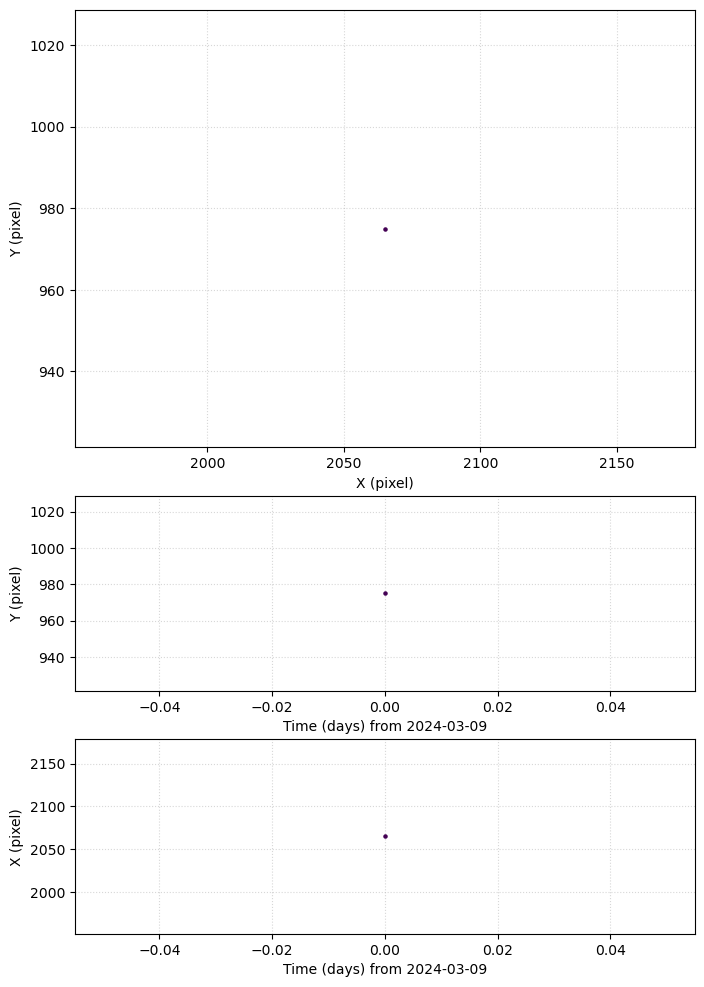

In [10]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    Ncol, Nrow = 2, 4

    fig = plt.figure(figsize=(8, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0:2, :])

    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])

    plt.subplots_adjust(hspace=0.25)


    ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax2.scatter(df0.time_sec*time_scaling, df0.y_idx_nan, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x_idx_nan, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y (pixel)")
    ax1.set_xlabel("X (pixel)")

    ax2.set_ylabel("Y (pixel)")
    ax2.set_xlabel(f"Time (days) from {str(df.time_local.iloc[0])[:10]}")

    ax3.set_ylabel("X (pixel)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_local.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BeamWander_RU.png", format="png", dpi=150, bbox_inches='tight')
